<h1>1D Ising Model: Monte Carlo Simulations</h1>
<h4>William Pugsley </h4>

In [82]:
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from math import sqrt, cosh, sinh, log, exp, tanh

#this module contains the statistical functions used throughout the simulation
from my_math import *

#Thermodynamic constants
k_B = 1.380649e-23 #Units: J/K

<h2>Algorithm</h2>

The Monte Carlo algorithm we will use (Holmes-Cerfon 6-9) consists of creating a grid of vectors free to spin in the XY plane, this will be realized as a d-dimensional array of 2-dimensional vectors with magntiudes of 1 and pointing in random directions. This algorithm will apply to any dimension d. We will randomly select a spin and calculate the energy change, $\Delta E$ associated with replacing the spin with a new random vector. The new state will be accepted with probability $Prob=W(\sigma',\sigma)$, where $W(\sigma',\sigma)$ satisfies the detailed balance equation (Grant 41); for our purposes this will be either the Glauber rule or the Metropolis rule. 

$W_{Metropolis}(\sigma',\sigma)=1 \; \Delta E \leq 0, \: e^{\frac{-\Delta E}{k_BT}} \; \Delta E \gt 0$

$W_{Glauber}(\sigma',\sigma)=\frac{1}{2}(1-tanh(\frac{\Delta E}{2k_BT}))$

We will do this N times for N total spins, this is one Monte Carlo cycle. Completing N cycles for our N spins will consist of one Monte Carlo simulation (Grant 45). At the end of a simulation we can calculate the total magnetization and the magnetization per spin; with these quantities we can verify our theoretical expectation of $<m>$. Repeating for diferent temperatures should yield the temperature dependence of $<m>$. The correlation function, $<S_iS_{i+r}>$ can also be calculated from the same simulation.

<h2>1-Dimensional XY Model</h2>

The one-dimensional XY model consists of a strip of N sites each containing a spin, $\vec{S_i}$, such that $|\vec{S_i}|=1$ and $\vec{S_i}$ is pointing in a random direction for all i=1,...,N. The energy of a state is defined such that neighboring spins pointing in the same direction as well as spins pointing in the direction of an external field, H, are favored.

$E_{state}=-J\sum_{j=1}^{N}\vec{S_j}\cdot\vec{S_{j+1}} - H\sum_{j=1}^N\vec{S_i}$ 

J is strength of interactions between neighboring spins

<h4>Setup</h4>

In [83]:
#the Vector class used throughout this simulation is imported from the my_math module
def rand_unit_xy():
    """ (int) -> (Vector)
    Generates a 2-dimensional unit vector pointing in a random direction.
    """
    return Vector([random.uniform(-1,1), random.uniform(-1,1)]).unit()

def init_grid_1d(length):
    """ (int) -> (list)
    Creates a list with 'length' entries of random 2D Vectors.
    """
    return [rand_unit_xy() for i in range(length)]

def total_mag_1d(grid):
    """ (list) -> (num)
    Calculates the magnitude of the total magnetization of a 1-dimensional grid of 2D Vectors.
    """
    tot = Vector([0,0]) #total
    for spin in grid:
        tot += spin
    return tot.magnitude()

def mag_per_spin_1d(grid):
    """ (list) -> (float)
    Calculates the magnitude of the magnetization per spin of a 1-dimensional grid of 2D Vectors.
    """
    return total_mag_1d(grid)/len(grid)

def energy_1d(grid, H=None):
    """ (list, Vector) -> (num)
    Calculates the total energy of a one-dimensional grid of 2D Vectors with an external field, H,
    represented by another 2D Vector.
    """
    if H is None:
        H = Vector([0,0])
        
    e = 0
    N = len(grid)

    for i in range(N): #interaction between spins
        e += grid[i].dot(grid[(i+1)%N])

    for spin in grid: #external field interactions
        e += H.dot(spin)
    
    return -e

def print_grid_1d(grid):
    """ (list) -> (None)
    Prints a visulation of the one-dimensional grid given as input.
    """
    s = "|"
    for spin in grid:
        s += str(spin) + ", "
    print(s[:-2] + "|")

In [84]:
def energy_change_1d(grid, idx, vec, H=None):
    """ (list, int, Vector, Vector) -> (int)
    Calculates the energy change associated with flipping the spin at the idx position to the vec Vector. 
    The change is in units of J. H is the external field also in units of J.
    """
    if H is None:
        H = Vector([0,0])

    n = len(grid)
    # change in E = E_final - E_initial
    return -vec.dot(grid[(idx+1)%n]) - H.dot(vec) + grid[idx].dot(grid[(idx+1)%n]) + H.dot(grid[idx])

#we can use the Glauber rule to calculate the probability of a state transition
def glauber_1d(grid, idx, vec, temp, H=None):
    """ (list, int, Vector, float, Vector) -> (float)
    Calculates the probability that a change of state of a 1-dimensional grid, with energy change given by energy, 
    will occur at a given temperature, temp. The probability is calculated using the Glauber rule. 
    """ 
    energy = energy_change_1d(grid, idx, vec, H)
    return 0.5*(1 - tanh(0.5*energy/temp))

#we can also use metropolis rule
def metropolis_1d(grid, idx, vec, temp, H=None):
    """ (list, int, Vector, float, Vector) -> (float)
    Calculates the probability that a change of state of a 1-dimensional grid, with energy change given by energy, 
    will occur at a given temperature, temp. The probability is calculated using the Metropolis rule. 
    """
    energy = energy_change_1d(grid, idx, vec, H)
    if energy <= 0:
        return 1
    return exp(-energy/temp)


def flip_1d(grid, idx, temp, H=None, rule="metropolis"):
    """ (list, int, Vector, float) -> ()
    Flips the spin in grid at site idx with a probability given by the Glauber or Metropolis rule at temperature temp.
    """
    vec = rand_unit_xy() #new unit Vector

    if rule == "glauber":
        prob = glauber_1d(grid, idx, vec, temp, H)
    elif rule == "metropolis":
        prob = metropolis_1d(grid, idx, vec, temp, H)
    else:
        raise ValueError("The rule argument take \"glauber\" or \"metropolis\" as input.") 

    choice = random.uniform(0, 1)
    
    if choice <= prob: #will flip
        grid[idx] = vec
    #otherwise will not flip and nothing happens

def cycle_1d(grid, temp, H=None, rule='metropolis'):
    """ (list, float, Vector, str) -> ()
    Will conduct one Monte Carlo cycle over grid at temperature temp. 
    """
    length = len(grid) 
    for i in range(length): #test flip at each site
        idx = random.randint(0, length-1)
        flip_1d(grid, idx, temp, H, rule)

def simulation_1d(grid, temp, H=None, rule='metropolis'):
    """ (list, float, Vector, str) -> ()
    Will conduct one Monte Carlo simulation over grid at temperature temp. 
    """
    length = len(grid)
    for i in range(length): #N Monte Carlo cycles for N sites is one simulation
        cycle_1d(grid, temp, H, rule)

In [85]:
def correlation_1d(grid, r):
    """ (np.array, int) -> (float)
    Returns the expected value of correlations <Si*Si+r> of a one-dimensional strip.
    """
    length = len(grid)
    return mean([grid[i].dot(grid[(i+r)%length]) for i in range(length)])

def plot_quiver_1d(grid):
    """ (list) -> (None)
    Given a 1D list of Vectors, plots the quiver plot of this XY grid.
    """
    X = [x for x in range(len(grid))]
    Y = [0 for x in range(len(grid))]

    U = []
    V = []
    for spin in grid:
        U.append(spin[0])
        V.append(spin[1])

    plt.figure()
    plt.quiver(X,Y,U,V)
    #plt.xticks([])
    plt.yticks([])
    plt.show()

<h4>Simulation</h4>

We will create a one-dimensional strip of N sites and run a total of num_sim Monte Carlo simulations before recording the magnetization per spin. We will do this num_points times, to get that many data points, at each temperature T in temperatues. Increasing num_points will get us a more precise measurement of the magnetization per spin at different temperatures. Increasing num_sim will let our experimental results approach the long-time thermodynamic limit 

In [87]:
def full_sim_1d(N, num_points, num_sim, temperatures, H=None, output='mag', rule='metropolis'):
    """ (int, int, int, np.array, Vector, str, str) -> (list, list)
    N: total number of spin sites
    num_points: number of data points at each temperature
    num_sim: total numer of simulations conducted on a strip
    temperatures: range of temperatues at which we will simulate
    H: the strength of the external field
    output: the variable we are measuring (magnetization per spin, correlation function, or energy per spin) 
    """
    if output == "mag":
        magnetizations = [] #<m> of our simulations at various temperatues
        magnetizations_unc = [] #uncertainties in <m>

        for T in temperatures:
            m_at_t = []
            strip = init_grid_1d(N)
            for i in range(num_sim): #we do num_sim simulations for each strip
                cycle_1d(strip, T, H, rule)
            for j in range(num_points): #we do num_points simulations at each temperature for that many data points
                cycle_1d(strip, T, H, rule)
                m_at_t.append(mag_per_spin_1d(strip))
            magnetizations.append(mean(m_at_t))
            magnetizations_unc.append(standard_error(m_at_t))
        return magnetizations, magnetizations_unc
    elif output == "energy":
        energies = [] #<E> of our simulations at various temperatues
        energies_unc = [] #uncertainties in <E>

        for T in temperatures:
            e_at_t = []
            strip = init_grid_1d(N)
            for i in range(num_sim): #we do num_sim simulations for each strip
                cycle_1d(strip, T, H, rule)
            for j in range(num_points): #we do num_points simulations at each temperature for that many data points
                cycle_1d(strip, T, H, rule)
                e_at_t.append(energy_1d(strip, H)/len(strip)) #energy per spin
            energies.append(mean(e_at_t))
            energies_unc.append(standard_error(e_at_t))
        return energies, energies_unc
    elif output == "corr": #finds the correlation function of the 1D Ising model at the first value in temperatures
        correlations = [[] for i in range(N//2)] #list of all the data points at each r
        T = temperatures[0]

        strip = init_grid_1d(N)
        for i in range(num_sim): #we do num_sim simulations for each strip
            cycle_1d(strip, T, H, rule)

        for j in range(num_points): #we want num_points data points at each r
            cycle_1d(strip, T, H, rule)
            for r in range(N//2):
                correlations[r].append(abs(correlation_1d(strip, r)))

        correlations_unc = [standard_error(x) for x in correlations] #uncertainty at each r
        for k in range(len(correlations)): #average at each r
            correlations[k] = mean(correlations[k])

        return correlations, correlations_unc
    raise ValueError("The output paramter must be \"mag\", \"energy\", or \"corr\".")

<h4>H=0</h4>

In [88]:
#these values will be stored in separate variables so that we may easily change them
length = 100
num_points = 50
num_sim = 3
temperatures_h_0 = np.linspace(0.1, 2, 15) #the range of temperatures over which we will run our simulation

magnetizations, magnetizations_unc = full_sim_1d(length, num_points, num_sim, temperatures_h_0, output='mag') #run the simulation

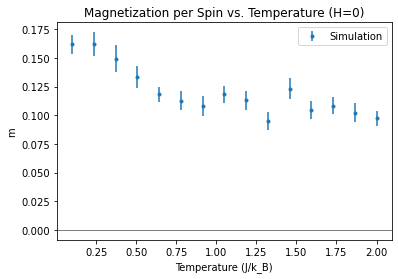

"\nres_1d_stderror = standard_error(residuals_1d)\nresiduals_1d_unc = [res_1d_stderror for i in residuals_1d]\n\nplt.errorbar(x=temperatures_h_0, y=residuals_1d, yerr=residuals_1d_unc, color='k', marker='.', ls='') #plotting residuals of <m>\n\nplt.title('Residuals of Magnetizations per Spin vs. Temperature (H=0)')\nplt.xlabel('Temperatures (J/k_B)')\nplt.ylabel('m')\nplt.axhline(color='k', lw=0.5)\nplt.show()\n"

<Figure size 432x288 with 0 Axes>

In [89]:
plt.figure()

plt.errorbar(x=temperatures_h_0, y=magnetizations, yerr=magnetizations_unc, marker='.', ls='', label='Simulation') #simulation results for <m>
#plt.plot(temperatures_h_0, exp_m, 'r-', label='Expected') #expected: <m>=0

plt.legend(loc='best')
plt.title("Magnetization per Spin vs. Temperature (H=0)")
plt.ylabel("m")
plt.xlabel("Temperature (J/k_B)")
plt.axhline(color='k', lw=0.5)
plt.show()


plt.figure()

#the following two lines of code are so our residuals will have error bars
"""
res_1d_stderror = standard_error(residuals_1d)
residuals_1d_unc = [res_1d_stderror for i in residuals_1d]

plt.errorbar(x=temperatures_h_0, y=residuals_1d, yerr=residuals_1d_unc, color='k', marker='.', ls='') #plotting residuals of <m>

plt.title('Residuals of Magnetizations per Spin vs. Temperature (H=0)')
plt.xlabel('Temperatures (J/k_B)')
plt.ylabel('m')
plt.axhline(color='k', lw=0.5)
plt.show()
"""

We can run a very similar simulation for the energies when H=0.

In [90]:
#these values will be stored in separate variables so that we may easily change them
length = 100
num_points = 50
num_sim = 3
temperatures_h_0 = np.linspace(0.1, 2, 15) #the range of temperatures over which we will run our simulation

energies, energies_unc = full_sim_1d(length, num_points, num_sim, temperatures_h_0, output='energy') #run the simulation

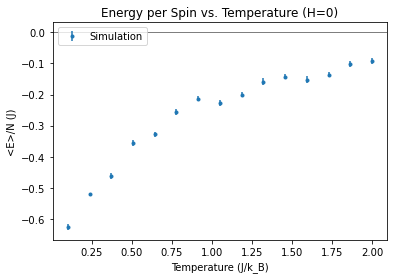

"\nres_1d_stderror = standard_error(residuals_1d)\nresiduals_1d_unc = [res_1d_stderror for i in residuals_1d]\n\nplt.errorbar(x=temperatures_h_0, y=residuals_1d, yerr=residuals_1d_unc, color='k', marker='.', ls='') #plotting residuals of <m>\n\nplt.title('Residuals of Energy per Spin vs. Temperature (H=0)')\nplt.xlabel('Temperatures (J/k_B)')\nplt.ylabel('<E>/N (J)')\nplt.axhline(color='k', lw=0.5)\nplt.show()\n"

<Figure size 432x288 with 0 Axes>

In [91]:
plt.figure()

plt.errorbar(x=temperatures_h_0, y=energies, yerr=energies_unc, marker='.', ls='', label='Simulation') #simulation results for <e>
#plt.plot(temperatures_h_0, exp_e, 'r-', label='Expected') #expected: <e>=0

plt.legend(loc='upper left')
plt.title("Energy per Spin vs. Temperature (H=0)")
plt.ylabel("<E>/N (J)")
plt.xlabel("Temperature (J/k_B)")
plt.axhline(color='k', lw=0.5)
plt.show()


plt.figure()

#the following two lines of code are so our residuals will have error bars
"""
res_1d_stderror = standard_error(residuals_1d)
residuals_1d_unc = [res_1d_stderror for i in residuals_1d]

plt.errorbar(x=temperatures_h_0, y=residuals_1d, yerr=residuals_1d_unc, color='k', marker='.', ls='') #plotting residuals of <m>

plt.title('Residuals of Energy per Spin vs. Temperature (H=0)')
plt.xlabel('Temperatures (J/k_B)')
plt.ylabel('<E>/N (J)')
plt.axhline(color='k', lw=0.5)
plt.show()
"""

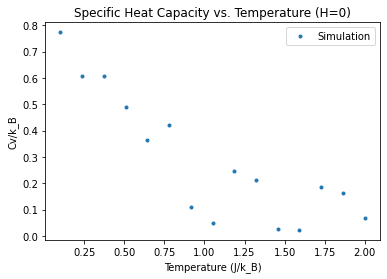

In [92]:
c_v_h_0 = list_derivative(temperatures_h_0, energies)

"""
def cvh0_expected(temp):
    return (1/cosh(1/temp))**2/temp

exp_cv = [cvh0_expected(T) for T in temperatures_h_0]
"""

plt.figure()

plt.plot(temperatures_h_0, c_v_h_0, marker='.', ls='', label='Simulation')
#plt.plot(temperatures_h_0, exp_cv, 'r-', label='Expected')

plt.title("Specific Heat Capacity vs. Temperature (H=0)")
plt.xlabel("Temperature (J/k_B)")
plt.ylabel("Cv/k_B")
plt.legend()
plt.show()

Next we will consider the correlation function.

In [93]:
#these values will be stored in separate variables so that we may easily change them
length = 50
num_points = 50
num_sim = 10

#correlation function at low, medium, and high temperatures
corr_low_t, corr_low_t_unc = full_sim_1d(length, num_points, num_sim, [0.1], output="corr")
corr_med_t, corr_med_t_unc = full_sim_1d(length, num_points, num_sim, [1], output="corr")
corr_high_t, corr_high_t_unc = full_sim_1d(length, num_points, num_sim, [10], output="corr")

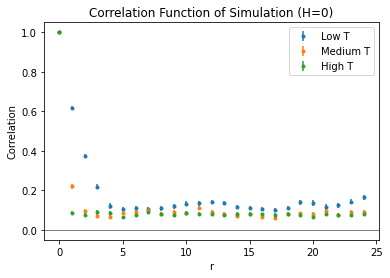

In [94]:
r = range(length//2)

plt.figure()

#correlation results at various temperatures
plt.errorbar(x=r, y=corr_low_t, yerr=corr_low_t_unc, marker='.', ls='None', label="Low T") 
plt.errorbar(x=r, y=corr_med_t, yerr=corr_med_t_unc, marker='.', ls='None', label="Medium T") 
plt.errorbar(x=r, y=corr_high_t, yerr=corr_high_t_unc, marker='.', ls='None', label="High T") 

plt.title("Correlation Function of Simulation (H=0)")
plt.xlabel("r")
plt.ylabel("Correlation")

plt.legend()
plt.axhline(color='k', lw=0.5)
plt.show()

<h4>H&#8800;0</h4>

In [95]:
#these values will be stored in separate variables so that we may easily change them
length = 20
num_points = 10
num_sim = 1
temperatures = np.linspace(0.1, 2, 19) #the range of temperatures over which we will run our simulation

mag_minus5, mag_unc_minus5 = full_sim_1d(length, num_points, num_sim, temperatures, Vector([-5,0])) #H=<-5,0>
mag_minus1, mag_unc_minus1 = full_sim_1d(length, num_points, num_sim, temperatures, Vector([0,-1])) #H=<0,-1>
mag_1, mag_unc_1 = full_sim_1d(length, num_points, num_sim, temperatures, Vector([1,0])) #H=<1,0>
mag_5, mag_unc_5 = full_sim_1d(length, num_points, num_sim, temperatures, Vector([0,5])) #H=<0,5>

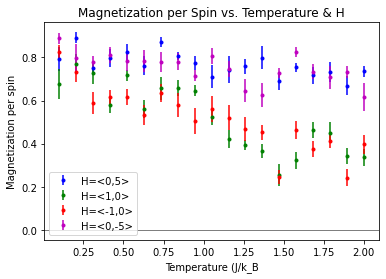

In [96]:
plt.figure()

#simulation results
plt.errorbar(x=temperatures, y=mag_5, yerr=mag_unc_5, label="H=<0,5>", color='b', marker='.', ls='')
plt.errorbar(x=temperatures, y=mag_1, yerr=mag_unc_1, label="H=<1,0>", color='g', marker='.', ls='')
plt.errorbar(x=temperatures, y=mag_minus1, yerr=mag_unc_minus1, label="H=<-1,0>", color='r', marker='.', ls='')
plt.errorbar(x=temperatures, y=mag_minus5, yerr=mag_unc_minus5, label="H=<0,-5>", color='m', marker='.', ls='')

"""
#expectation values
plt.plot(temperatures, expected5, color='b')
plt.plot(temperatures, expected1, color='g')
plt.plot(temperatures, expected_minus1, color='r')
plt.plot(temperatures, expected_minus5, color='m')
"""

plt.title("Magnetization per Spin vs. Temperature & H")
plt.xlabel("Temperature (J/k_B")
plt.ylabel("Magnetization per spin")
plt.legend()
plt.axhline(color='k', lw=0.5)
plt.show()

<h2>Sources</h2>

* Grant, Martin. <em>Dirty tricks for statistical mechanics</em>. 2004.
    * Available here: <http://www.physics.mcgill.ca/~grant/559/notes0.91.pdf>
* Holmes-Cerfon, Miranda. <em>Lecture 3: Markov Chains (II): Detailed Balance, and Markov Chain Monte Carlo (MCMC)</em>. 2019.
    * Available here: <https://cims.nyu.edu/~holmes/teaching/asa19/handout_Lecture3_2019.pdf>
* Pathria, R. K., and Paul D. Beale. <em>Statistical Mechanics</em>. Elsevier, 2011. 